In [18]:
""" 
21 MARCH 2024 
Theo Gauvrit
Testing if the responsivity pattern are different between WT and KO groups
"""

import numpy as np
import pandas as pd
import percephone.core.recording as pc
import os
import percephone.plts.behavior as pbh
import matplotlib
import percephone.plts.stats as ppt
import matplotlib.pyplot as plt
import percephone.analysis.mlr_models as mlr_m
from multiprocessing import Pool, cpu_count
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 2
plt.switch_backend("Qt5Agg")
matplotlib.use("Qt5Agg")
%matplotlib inline

In [19]:
directory = "/datas/Théo/Projects/Percephone/data/Amplitude_Detection/loop_format_tau_02/"
roi_info = pd.read_excel(directory + "/FmKO_ROIs&inhibitory.xlsx")
files = os.listdir(directory)
files_ = [file for file in files if file.endswith("synchro")]

def opening_rec(fil,i):
    rec = pc.RecordingAmplDet(directory + fil + "/", 0, fil, roi_info)
    return rec

workers = cpu_count()
pool = Pool(processes=workers)
async_results = [pool.apply_async(opening_rec, args=(file,i)) for i,file in enumerate(files_)]
recs = {ar.get().filename: ar.get() for ar in async_results}


Behavioural information already incorporated in the analog.Behavioural information already incorporated in the analog.

Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.Behavioural information already incorporated in the analog.

Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.Behavioural information already incorporated in the analog.


Percentage of exc neurons recruited (1 and -1) during stimulus detected and undetected

Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.9627565145492554, pvalue=0.8359125256538391)
ShapiroResult(statistic=0.9714000821113586, pvalue=0.9017041325569153)
Ttest_indResult(statistic=0.7147519928996814, pvalue=0.48843463296544354)
Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.9052245020866394, pvalue=0.3216565251350403)
ShapiroResult(statistic=0.8682674765586853, pvalue=0.21938610076904297)
Ttest_indResult(statistic=-1.4087189668438536, pvalue=0.184298923268913)


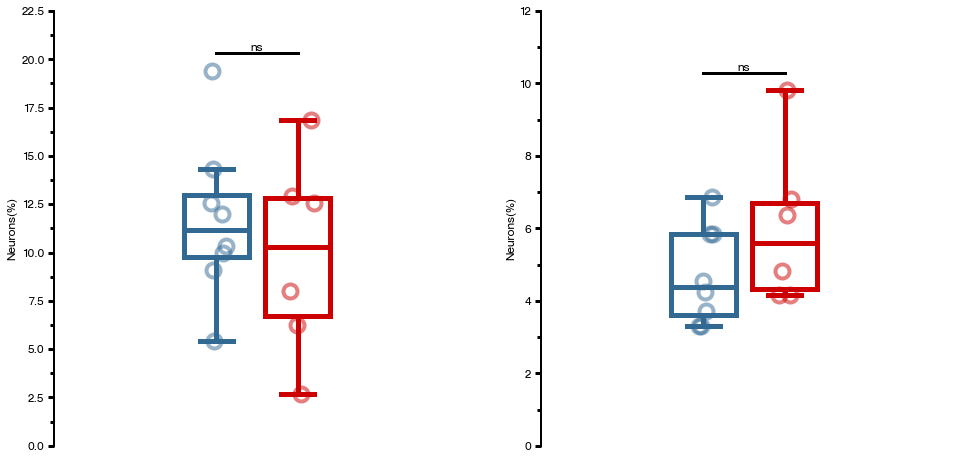

In [20]:
wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
for rec in recs.values():

    resp_mat = np.array(rec.matrices['EXC']["Responsivity"])
    #detected
    trials_detected = resp_mat[:,rec.detected_stim]
    trials_detected[trials_detected!=0]=1
    recruited_det = np.sum(trials_detected,axis=0)
    perc_n_det = (np.mean(recruited_det)/len(rec.zscore_exc))*100
    #undetected
    trials_undetected = resp_mat[:,~rec.detected_stim]
    trials_undetected[trials_undetected!=0]=1
    recruited_undet = np.sum(trials_undetected,axis=0)
    perc_n_undet = (np.mean(recruited_undet)/len(rec.zscore_exc))*100
    if rec.genotype == "WT":
        wt_det.append(perc_n_det)
        wt_undet.append(perc_n_undet )
    else:
        ko_det.append(perc_n_det)
        ko_undet.append(perc_n_undet)
fig, axs = plt.subplots(1,2,figsize=(16,8))
ppt.boxplot(axs[0], wt_det,ko_det,"Neurons(%)",ylim=[])
ppt.boxplot(axs[1], wt_undet,ko_undet,"Neurons(%)",ylim=[])

Percentage of exc neurons activated (1) during stimulus detected and undetected


Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.9542219638824463, pvalue=0.753615140914917)
ShapiroResult(statistic=0.9709689021110535, pvalue=0.8988787531852722)
Ttest_indResult(statistic=0.42280989286947457, pvalue=0.6799118300058156)
Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.9173423051834106, pvalue=0.4086715579032898)
ShapiroResult(statistic=0.8407193422317505, pvalue=0.13216456770896912)
Ttest_indResult(statistic=-1.3080533520008444, pvalue=0.21535782628664166)


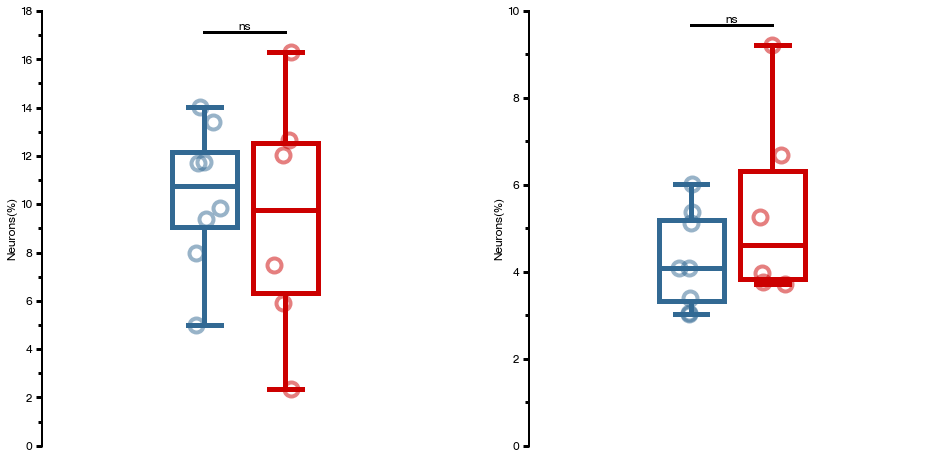

In [21]:
wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
for rec in recs.values():
    resp_mat = np.array(rec.matrices['EXC']["Responsivity"])
    #detected
    trials_detected = resp_mat[:,rec.detected_stim]
    trials_detected[trials_detected!=1]=0
    recruited_det = np.sum(trials_detected,axis=0)
    perc_n_det = (np.mean(recruited_det)/len(rec.zscore_exc))*100
    #undetected
    trials_undetected = resp_mat[:,~rec.detected_stim]
    trials_undetected[trials_undetected!=1]=0
    recruited_undet = np.sum(trials_undetected,axis=0)
    perc_n_undet = (np.mean(recruited_undet)/len(rec.zscore_exc))*100
    if rec.genotype == "WT":
        wt_det.append(perc_n_det)
        wt_undet.append(perc_n_undet )
    else:
        ko_det.append(perc_n_det)
        ko_undet.append(perc_n_undet)
fig, axs = plt.subplots(1,2,figsize=(16,8))
ppt.boxplot(axs[0], wt_det,ko_det,"Neurons(%)",ylim=[])
ppt.boxplot(axs[1], wt_undet,ko_undet,"Neurons(%)",ylim=[])

Percentage of exc neurons inhibited (-1) during stimulus detected and undetected

Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.5550285577774048, pvalue=4.696400719694793e-05)
ShapiroResult(statistic=0.8967295289039612, pvalue=0.3549595773220062)
MannwhitneyuResult(statistic=34.0, pvalue=0.22843822843822847)
Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.92536461353302, pvalue=0.47488272190093994)
ShapiroResult(statistic=0.9779413938522339, pvalue=0.940879225730896)
Ttest_indResult(statistic=-0.946702664776005, pvalue=0.3624647420379342)


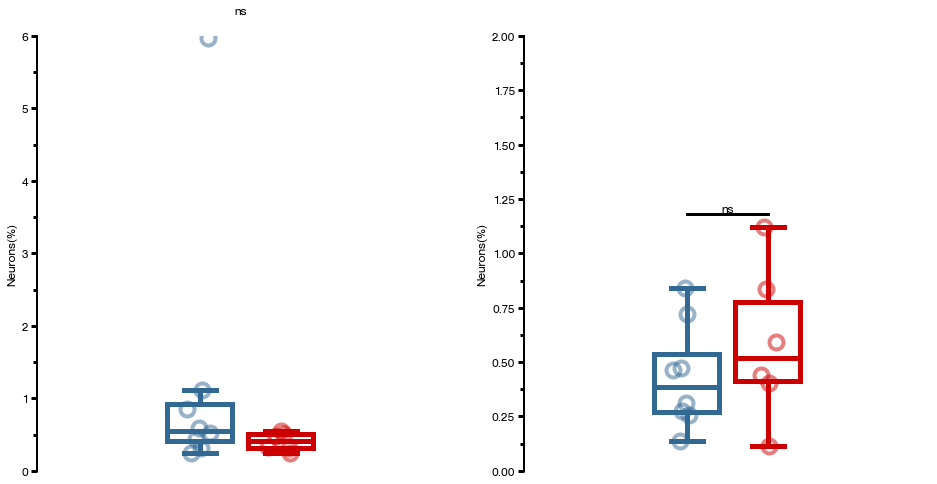

In [35]:
wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
for rec in recs.values():
    resp_mat = np.array(rec.matrices['EXC']["Responsivity"])
    #detected
    trials_detected = resp_mat[:,rec.detected_stim]
    trials_detected[trials_detected!=-1]=0
    trials_detected[trials_detected==-1]=1
    recruited_det = np.sum(trials_detected,axis=0)
    perc_n_det = (np.mean(recruited_det)/len(rec.zscore_exc))*100
    #undetected
    trials_undetected = resp_mat[:,~rec.detected_stim]
    trials_undetected[trials_undetected!=-1]=0
    trials_undetected[trials_undetected==-1]=1
    recruited_undet = np.sum(trials_undetected,axis=0)
    perc_n_undet = (np.mean(recruited_undet)/len(rec.zscore_exc))*100
    if rec.genotype == "WT":
        wt_det.append(perc_n_det)
        wt_undet.append(perc_n_undet )
    else:
        ko_det.append(perc_n_det)
        ko_undet.append(perc_n_undet)
fig, axs = plt.subplots(1,2,figsize=(16,8))
ppt.boxplot(axs[0], wt_det,ko_det,"Neurons(%)",ylim=[])
ppt.boxplot(axs[1], wt_undet,ko_undet,"Neurons(%)",ylim=[])

# INHIBITORY NEURONS

Percentage of inh neurons recruited (1 and -1) during stimulus detected and undetected


Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.8429317474365234, pvalue=0.08072026073932648)
ShapiroResult(statistic=0.885936975479126, pvalue=0.2974434494972229)
Ttest_indResult(statistic=1.56351071246467, pvalue=0.1439078958001875)
Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.8859447836875916, pvalue=0.21444639563560486)
ShapiroResult(statistic=0.9793760776519775, pvalue=0.9484145641326904)
Ttest_indResult(statistic=0.3039584518749062, pvalue=0.7663656679590305)


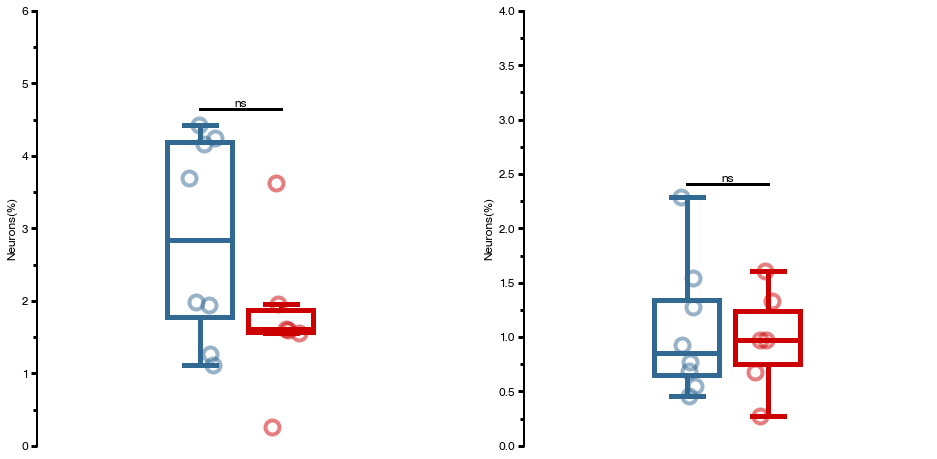

In [23]:
wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
for rec in recs.values():
    resp_mat = np.array(rec.matrices['INH']["Responsivity"])
    #detected
    trials_detected = resp_mat[:,rec.detected_stim]
    trials_detected[trials_detected!=0]=1
    recruited_det = np.sum(trials_detected,axis=0)
    perc_n_det = (np.mean(recruited_det)/len(rec.zscore_exc))*100
    #undetected
    trials_undetected = resp_mat[:,~rec.detected_stim]
    trials_undetected[trials_undetected!=0]=1
    recruited_undet = np.sum(trials_undetected,axis=0)
    perc_n_undet = (np.mean(recruited_undet)/len(rec.zscore_exc))*100
    if rec.genotype == "WT":
        wt_det.append(perc_n_det)
        wt_undet.append(perc_n_undet )
    else:
        ko_det.append(perc_n_det)
        ko_undet.append(perc_n_undet)
fig, axs = plt.subplots(1,2,figsize=(16,8))
ppt.boxplot(axs[0], wt_det,ko_det,"Neurons(%)",ylim=[])
ppt.boxplot(axs[1], wt_undet,ko_undet,"Neurons(%)",ylim=[])

Percentage of inh neurons activated (1) during stimulus detected and undetected


Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.7897278070449829, pvalue=0.022200193256139755)
ShapiroResult(statistic=0.9538654088973999, pvalue=0.7714341878890991)
MannwhitneyuResult(statistic=29.0, pvalue=0.5727605727605728)
Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.838668704032898, pvalue=0.07298516482114792)
ShapiroResult(statistic=0.9625425934791565, pvalue=0.8391063809394836)
Ttest_indResult(statistic=1.051530052029855, pvalue=0.31373013563067453)


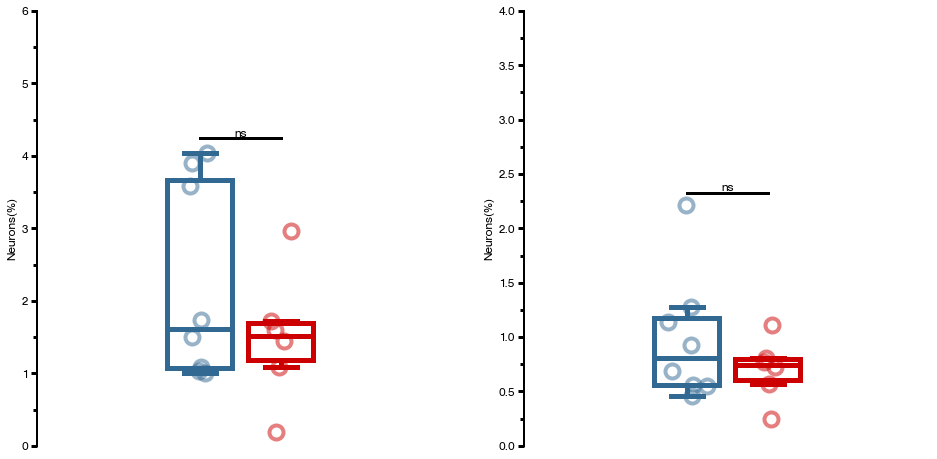

In [24]:
wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
for rec in recs.values():
    resp_mat = np.array(rec.matrices['INH']["Responsivity"])
    #detected
    trials_detected = resp_mat[:,rec.detected_stim]
    trials_detected[trials_detected!=1]=0
    recruited_det = np.sum(trials_detected,axis=0)
    perc_n_det = (np.mean(recruited_det)/len(rec.zscore_exc))*100
    #undetected
    trials_undetected = resp_mat[:,~rec.detected_stim]
    trials_undetected[trials_undetected!=1]=0
    recruited_undet = np.sum(trials_undetected,axis=0)
    perc_n_undet = (np.mean(recruited_undet)/len(rec.zscore_exc))*100
    if rec.genotype == "WT":
        wt_det.append(perc_n_det)
        wt_undet.append(perc_n_undet )
    else:
        ko_det.append(perc_n_det)
        ko_undet.append(perc_n_undet)
fig, axs = plt.subplots(1,2,figsize=(16,8))
ppt.boxplot(axs[0], wt_det,ko_det,"Neurons(%)",ylim=[])
ppt.boxplot(axs[1], wt_undet,ko_undet,"Neurons(%)",ylim=[])

Percentage of inh neurons inhibited (-1) during stimulus detected and undetected

Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.6428825259208679, pvalue=0.0005009454907849431)
ShapiroResult(statistic=0.891539990901947, pvalue=0.32633569836616516)
MannwhitneyuResult(statistic=31.0, pvalue=0.4135864135864136)
Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.6866276264190674, pvalue=0.0015886106994003057)
ShapiroResult(statistic=0.7082570195198059, pvalue=0.00754410307854414)
MannwhitneyuResult(statistic=10.0, pvalue=0.07467463615009534)


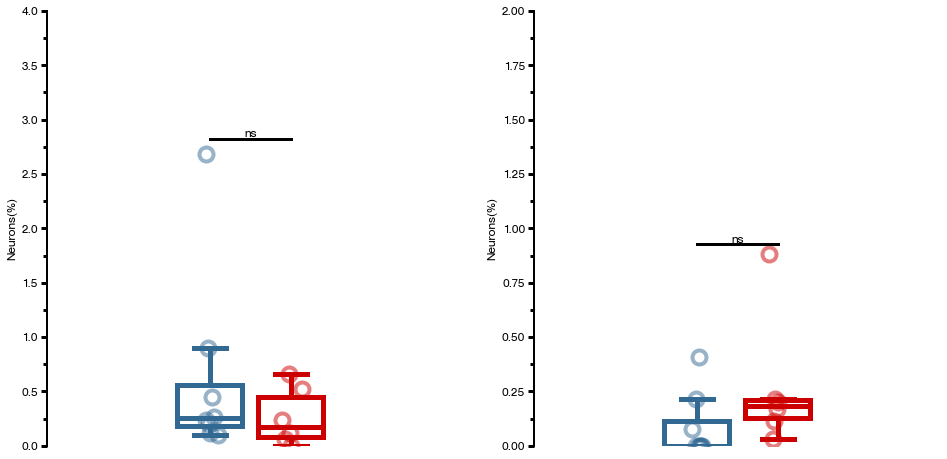

In [25]:
wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
for rec in recs.values():
    resp_mat = np.array(rec.matrices['INH']["Responsivity"])
    #detected
    trials_detected = resp_mat[:,rec.detected_stim]
    trials_detected[trials_detected!=-1]=0
    trials_detected[trials_detected==-1]=1
    recruited_det = np.sum(trials_detected,axis=0)
    perc_n_det = (np.mean(recruited_det)/len(rec.zscore_exc))*100
    #undetected
    trials_undetected = resp_mat[:,~rec.detected_stim]
    trials_undetected[trials_undetected!=-1]=0
    trials_undetected[trials_undetected==-1]=1
    recruited_undet = np.sum(trials_undetected,axis=0)
    perc_n_undet = (np.mean(recruited_undet)/len(rec.zscore_exc))*100
    if rec.genotype == "WT":
        wt_det.append(perc_n_det)
        wt_undet.append(perc_n_undet )
    else:
        ko_det.append(perc_n_det)
        ko_undet.append(perc_n_undet)
fig, axs = plt.subplots(1,2,figsize=(16,8))
ppt.boxplot(axs[0], wt_det,ko_det,"Neurons(%)",ylim=[])
ppt.boxplot(axs[1], wt_undet,ko_undet,"Neurons(%)",ylim=[])

#Comparison between WT vs KO-HYpo for recruited (+1 and -1) neurons


Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.9627565145492554, pvalue=0.8359125256538391)
ShapiroResult(statistic=0.8736763000488281, pvalue=0.3123304545879364)
Ttest_indResult(statistic=1.1351604265693245, pvalue=0.2827835926818015)
Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.9173423051834106, pvalue=0.4086715579032898)
ShapiroResult(statistic=0.6658903956413269, pvalue=0.00431289616972208)
MannwhitneyuResult(statistic=15.0, pvalue=0.9333333333333333)
Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.8429317474365234, pvalue=0.08072026073932648)
ShapiroResult(statistic=0.9321528673171997, pvalue=0.6071096658706665)
Ttest_indResult(statistic=1.2664338394008758, pvalue=0.2340615300161139)
Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.838668704032898, pvalue=0.07298516482114792)
ShapiroResult(statistic=0.9328802227973938, pvalue=0.6114290356636047)
Ttest_indResult(statistic=0.7571251376249069, pvalue=0.46643971339167456)


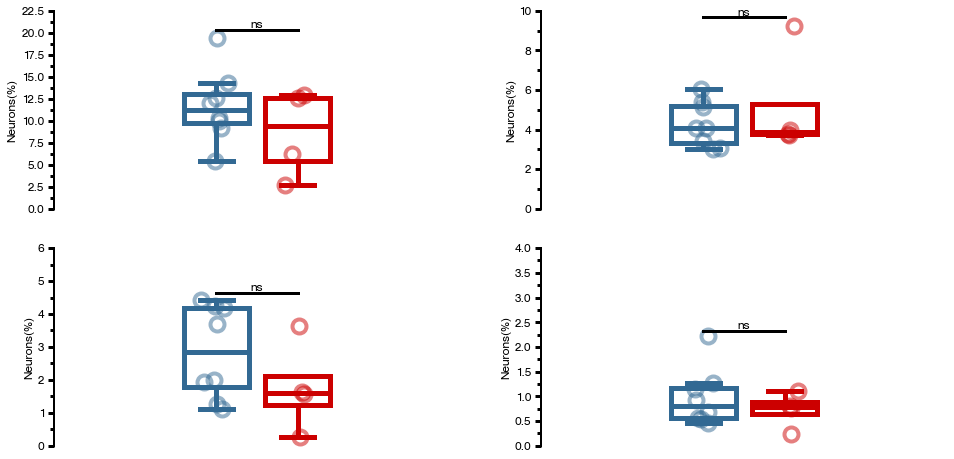

In [26]:
fig, axs = plt.subplots(2,2,figsize=(16,8))

for i,type in enumerate(["EXC","INH"]):
    wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
    for rec in recs.values():
        resp_mat = np.array(rec.matrices[type]["Responsivity"])
        #detected
        trials_detected = resp_mat[:,rec.detected_stim]
        trials_detected[trials_detected!=0]=1
        recruited_det = np.sum(trials_detected,axis=0)
        perc_n_det = (np.mean(recruited_det)/len(rec.zscore_exc))*100
        #undetected
        trials_undetected = resp_mat[:,~rec.detected_stim]
        trials_undetected[trials_undetected!=1]=0
        recruited_undet = np.sum(trials_undetected,axis=0)
        perc_n_undet = (np.mean(recruited_undet)/len(rec.zscore_exc))*100
        if rec.genotype == "WT":
            wt_det.append(perc_n_det)
            wt_undet.append(perc_n_undet )
        elif rec.genotype =="KO-Hypo":
            ko_det.append(perc_n_det)
            ko_undet.append(perc_n_undet)
    ppt.boxplot(axs[i,0], wt_det,ko_det,"Neurons(%)",ylim=[])
    ppt.boxplot(axs[i,1], wt_undet,ko_undet,"Neurons(%)",ylim=[])

#Comparison between WT vs KO-HYpo for activated (+1) neurons


Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.9542219638824463, pvalue=0.753615140914917)
ShapiroResult(statistic=0.8863587379455566, pvalue=0.3665056526660919)
Ttest_indResult(statistic=0.9447893049191871, pvalue=0.36703421519163104)
Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.9173423051834106, pvalue=0.4086715579032898)
ShapiroResult(statistic=0.6658903956413269, pvalue=0.00431289616972208)
MannwhitneyuResult(statistic=15.0, pvalue=0.9333333333333333)
Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.7897278070449829, pvalue=0.022200193256139755)
ShapiroResult(statistic=0.9635050892829895, pvalue=0.8009440302848816)
MannwhitneyuResult(statistic=21.0, pvalue=0.46060606060606063)
Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.838668704032898, pvalue=0.07298516482114792)
ShapiroResult(statistic=0.9328802227973938, pvalue=0.6114290356636047)
Ttest_indResult(statistic=0.7571251376249069, pvalue=0.46643971339167456)


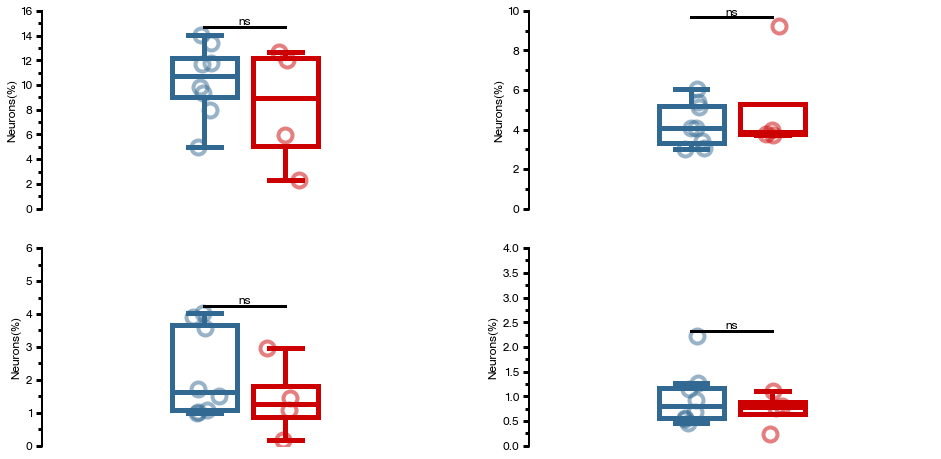

In [27]:
fig, axs = plt.subplots(2,2,figsize=(16,8))

for i,type in enumerate(["EXC","INH"]):
    wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
    for rec in recs.values():
        resp_mat = np.array(rec.matrices[type]["Responsivity"])
        #detected
        trials_detected = resp_mat[:,rec.detected_stim]
        trials_detected[trials_detected!=1]=0

        recruited_det = np.sum(trials_detected,axis=0)
        perc_n_det = (np.mean(recruited_det)/len(rec.zscore_exc))*100
        #undetected
        trials_undetected = resp_mat[:,~rec.detected_stim]
        trials_undetected[trials_undetected!=1]=0
        recruited_undet = np.sum(trials_undetected,axis=0)
        perc_n_undet = (np.mean(recruited_undet)/len(rec.zscore_exc))*100
        if rec.genotype == "WT":
            wt_det.append(perc_n_det)
            wt_undet.append(perc_n_undet )
        elif rec.genotype =="KO-Hypo":
            ko_det.append(perc_n_det)
            ko_undet.append(perc_n_undet)
    ppt.boxplot(axs[i,0], wt_det,ko_det,"Neurons(%)",ylim=[])
    ppt.boxplot(axs[i,1], wt_undet,ko_undet,"Neurons(%)",ylim=[])

#Comparison between WT vs KO-HYpo for inhibited (-1) neurons

Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.5550285577774048, pvalue=4.696400719694793e-05)
ShapiroResult(statistic=0.9174503087997437, pvalue=0.5227497816085815)
MannwhitneyuResult(statistic=25.0, pvalue=0.15353535353535355)
Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.92536461353302, pvalue=0.47488272190093994)
ShapiroResult(statistic=0.9010438323020935, pvalue=0.4362626373767853)
Ttest_indResult(statistic=-0.9520107074988591, pvalue=0.36353480988400944)
Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.6428825259208679, pvalue=0.0005009454907849431)
ShapiroResult(statistic=0.8703258633613586, pvalue=0.2989620566368103)
MannwhitneyuResult(statistic=18.0, pvalue=0.8080808080808081)
Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.6866276264190674, pvalue=0.0015886106994003057)
ShapiroResult(statistic=0.8246829509735107, pvalue=0.15435628592967987)
MannwhitneyuResult(statistic=8.0, pvalue=0.18655755234056515)


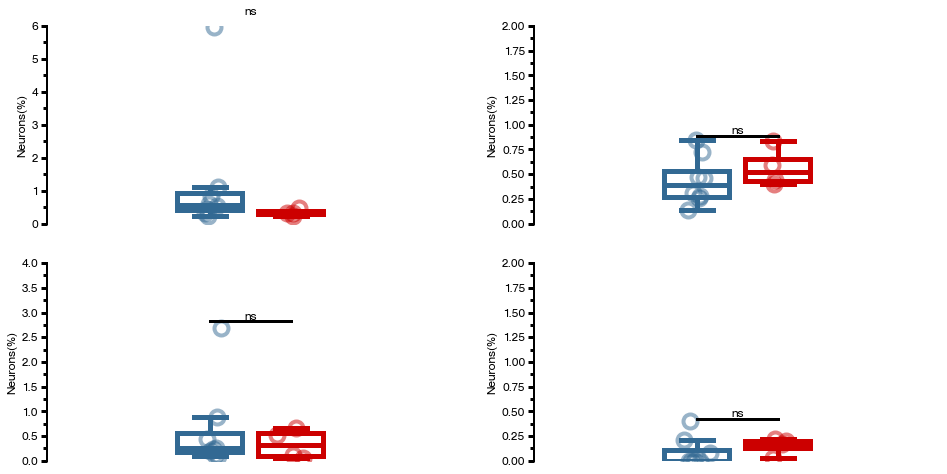

In [28]:
fig, axs = plt.subplots(2,2,figsize=(16,8))

for i,type in enumerate(["EXC","INH"]):
    wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
    for rec in recs.values():
        resp_mat = np.array(rec.matrices[type]["Responsivity"])
        #detected
        trials_detected = resp_mat[:,rec.detected_stim]
        trials_detected[trials_detected!=-1]=0
        trials_detected[trials_detected==-1]=1
        recruited_det = np.sum(trials_detected,axis=0)
        perc_n_det = (np.mean(recruited_det)/len(rec.zscore_exc))*100
        #undetected
        trials_undetected = resp_mat[:,~rec.detected_stim]
        trials_undetected[trials_undetected!=-1]=0
        trials_undetected[trials_undetected==-1]=1
        recruited_undet = np.sum(trials_undetected,axis=0)
        perc_n_undet = (np.mean(recruited_undet)/len(rec.zscore_exc))*100
        if rec.genotype == "WT":
            wt_det.append(perc_n_det)
            wt_undet.append(perc_n_undet )
        elif rec.genotype =="KO-Hypo":
            ko_det.append(perc_n_det)
            ko_undet.append(perc_n_undet)
    ppt.boxplot(axs[i,0], wt_det,ko_det,"Neurons(%)",ylim=[])
    ppt.boxplot(axs[i,1], wt_undet,ko_undet,"Neurons(%)",ylim=[])


Neurons inhibited for amp10

0.1
(49, 10)
0.1111111111111111
(101, 9)
0.8
(58, 15)
0.3125
(38, 16)
5.769230769230769
(127, 13)
0.42857142857142855
(91, 7)
0.8333333333333334
(103, 12)
0.2
(55, 10)
0.07692307692307693
(42, 13)
0.18181818181818182
(66, 11)
1.5
(125, 6)
0.9166666666666666
(76, 12)
0.7272727272727273
(98, 11)
0.5294117647058824
(131, 17)
Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.6829968094825745, pvalue=0.0014444802654907107)
ShapiroResult(statistic=0.8924626708030701, pvalue=0.3945927917957306)
MannwhitneyuResult(statistic=19.0, pvalue=0.6828282828282828)
Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.92536461353302, pvalue=0.47488272190093994)
ShapiroResult(statistic=0.9010438323020935, pvalue=0.4362626373767853)
Ttest_indResult(statistic=-0.9520107074988591, pvalue=0.36353480988400944)
0.0
(15, 10)
0.0
(19, 9)
0.5333333333333333
(13, 15)
0.1875
(9, 16)
3.076923076923077
(14, 13)
0.0
(29, 7)
0.4166666666666667
(19, 12)
0.1
(18, 10)
0.0
(5, 13)
0.18181818181818182
(20, 11)
0.1666

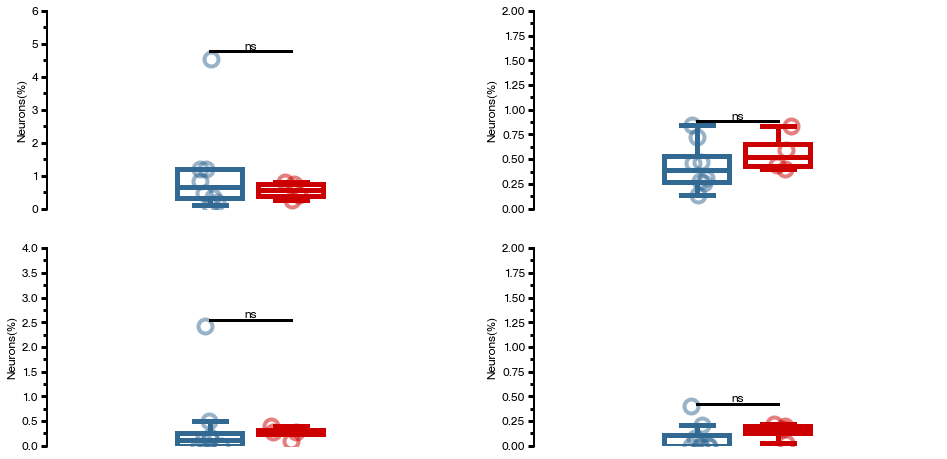

In [37]:
fig, axs = plt.subplots(2,2,figsize=(16,8))

for i,type in enumerate(["EXC","INH"]):
    wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
    for rec in recs.values():
        resp_mat = np.array(rec.matrices[type]["Responsivity"])
        #detected
        trials_detected = resp_mat[:,rec.stim_ampl==6]

        trials_detected[trials_detected!=-1]=0
        trials_detected[trials_detected==-1]=1
        recruited_det = np.sum(trials_detected,axis=0)
        print(np.mean(recruited_det))
        print(trials_detected.shape)
        perc_n_det = (np.mean(recruited_det)/len(rec.zscore_exc))*100
        #undetected
        trials_undetected = resp_mat[:,~rec.detected_stim]
        trials_undetected[trials_undetected!=-1]=0
        trials_undetected[trials_undetected==-1]=1
       
        recruited_undet = np.sum(trials_undetected,axis=0)
       
        perc_n_undet = (np.mean(recruited_undet)/len(rec.zscore_exc))*100
        if rec.genotype == "WT":
            wt_det.append(perc_n_det)
            wt_undet.append(perc_n_undet )
        elif rec.genotype =="KO-Hypo":
            ko_det.append(perc_n_det)
            ko_undet.append(perc_n_undet)
    ppt.boxplot(axs[i,0], wt_det,ko_det,"Neurons(%)",ylim=[])
    ppt.boxplot(axs[i,1], wt_undet,ko_undet,"Neurons(%)",ylim=[])

neurons activated for amplitude detected amplitude 8 trials

7.285714285714286
(49, 7)
3.4
(101, 5)
4.909090909090909
(58, 11)
5.235294117647059
(38, 17)
18.0
(127, 17)
8.666666666666666
(91, 3)
9.428571428571429
(103, 7)
6.363636363636363
(55, 11)
6.066666666666666
(42, 15)
3.2857142857142856
(66, 7)
8.0
(125, 7)
5.777777777777778
(76, 9)
9.666666666666666
(98, 15)
5.133333333333334
(131, 15)
Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.9344423413276672, pvalue=0.5573553442955017)
ShapiroResult(statistic=0.8649608492851257, pvalue=0.27837061882019043)
Ttest_indResult(statistic=1.35501746194304, pvalue=0.20522917423141995)
Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.92536461353302, pvalue=0.47488272190093994)
ShapiroResult(statistic=0.9010438323020935, pvalue=0.4362626373767853)
Ttest_indResult(statistic=-0.9520107074988591, pvalue=0.36353480988400944)
1.5714285714285714
(15, 7)
1.0
(19, 5)
0.9090909090909091
(13, 11)
0.7647058823529411
(9, 17)
2.3529411764705883
(14, 17)
3.6666666666666665
(29, 3)
1.0
(19, 7)
2.545454545454

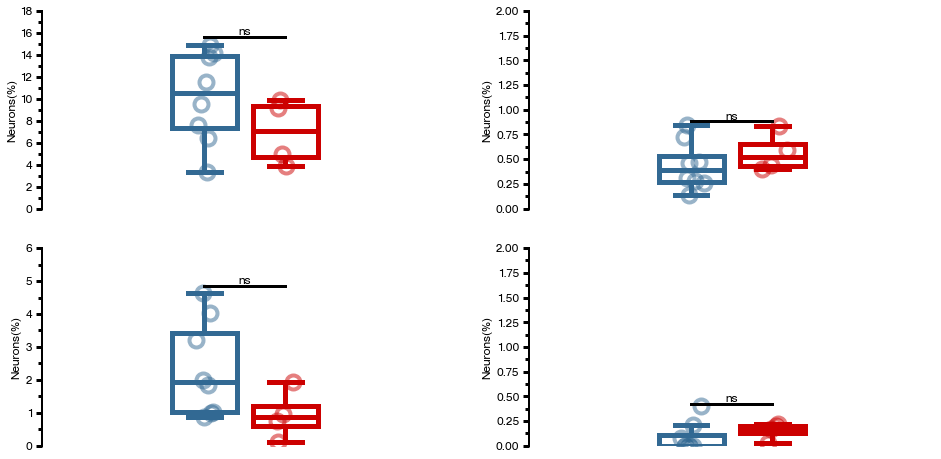

In [40]:
fig, axs = plt.subplots(2,2,figsize=(16,8))

for i,type in enumerate(["EXC","INH"]):
    wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
    for rec in recs.values():
        resp_mat = np.array(rec.matrices[type]["Responsivity"])
        #detected
        trials_detected = resp_mat[:,rec.stim_ampl==8]
        # trials_detected = trials_detected[~np.isnan(trials_detected)
        # if len(trials_detected)==0:
        #     continue
        trials_detected[trials_detected!=1]=0
        recruited_det = np.sum(trials_detected,axis=0)
        print(np.mean(recruited_det))
        print(trials_detected.shape)
        perc_n_det = (np.mean(recruited_det)/len(rec.zscore_exc))*100
        #undetected
        trials_undetected = resp_mat[:,~rec.detected_stim]
        trials_undetected[trials_undetected!=-1]=0
        trials_undetected[trials_undetected==-1]=1
       
        recruited_undet = np.sum(trials_undetected,axis=0)
       
        perc_n_undet = (np.mean(recruited_undet)/len(rec.zscore_exc))*100
        if rec.genotype == "WT":
            wt_det.append(perc_n_det)
            wt_undet.append(perc_n_undet )
        elif rec.genotype =="KO-Hypo":
            ko_det.append(perc_n_det)
            ko_undet.append(perc_n_undet)
    ppt.boxplot(axs[i,0], wt_det,ko_det,"Neurons(%)",ylim=[])
    ppt.boxplot(axs[i,1], wt_undet,ko_undet,"Neurons(%)",ylim=[])

# 22/03/2024  Threshold responsivity analysis

## Graph of activated neurons from amplitude

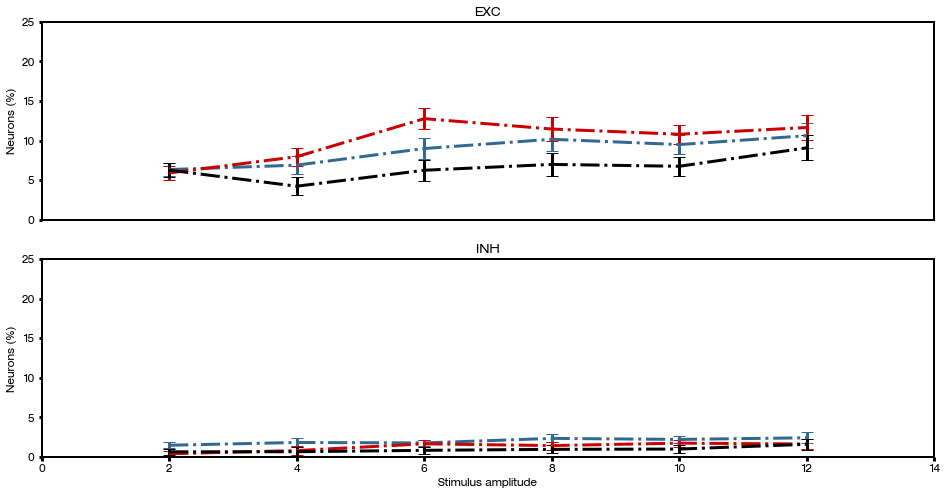

In [39]:
import scipy.stats as ss
figs, axs = plt.subplots(2,1,figsize=(16,8))

amps=[2,4,6,8,10,12]
for i,type in enumerate(["EXC","INH"]):
    wt,ko, ko_hypo = [],[],[]
    for rec in recs.values():
        resp_mat = np.array(rec.matrices[type]["Responsivity"])
        resp_p=[]
        for amp in amps:
            trials_detected = resp_mat[:,rec.stim_ampl==amp]
            trials_detected[trials_detected!=1]=0
            recruited_det = np.sum(trials_detected,axis=0)
            perc_n_det = (np.mean(recruited_det)/len(rec.zscore_exc))*100
            resp_p.append(perc_n_det)
        if rec.genotype == "WT":
            wt.append(resp_p)
        elif rec.genotype =="KO-Hypo":
            ko_hypo.append(resp_p)
        elif rec.genotype =="KO":
            ko.append(resp_p)
        

    axs[i].errorbar(amps,np.mean(wt,axis=0),linestyle="-.",color="#326993",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15)
    axs[i].errorbar(amps,np.mean(ko,axis=0),linestyle="-.", color="#CC0000",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15)
    axs[i].errorbar(amps,np.mean(ko_hypo,axis=0),linestyle="-.", color="black",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15)
    axs[i].set_ylabel("Neurons (%)")
    axs[i].set_xlabel("Stimulus amplitude")
    axs[i].set_xlim([0,14])
    axs[i].set_ylim([0,25])
    axs[i].set_title(type)

axs[0].get_xaxis().set_visible(False)



Number of active neurons and behavior psychometric curves comparison animal by animals

5889
(49, 54)
4939
(101, 54)
5893
(58, 80)
5886
(38, 82)
4456
(127, 87)
5873
(91, 27)
5881
(103, 53)
5879
(55, 68)
4754
(42, 82)
5890
(66, 72)
4745
(125, 55)
5896
(76, 75)
4445
(98, 84)
4756
(131, 90)


Text(0.5, 0.98, 'Percentage of neurons recruited for all trials amplitude')

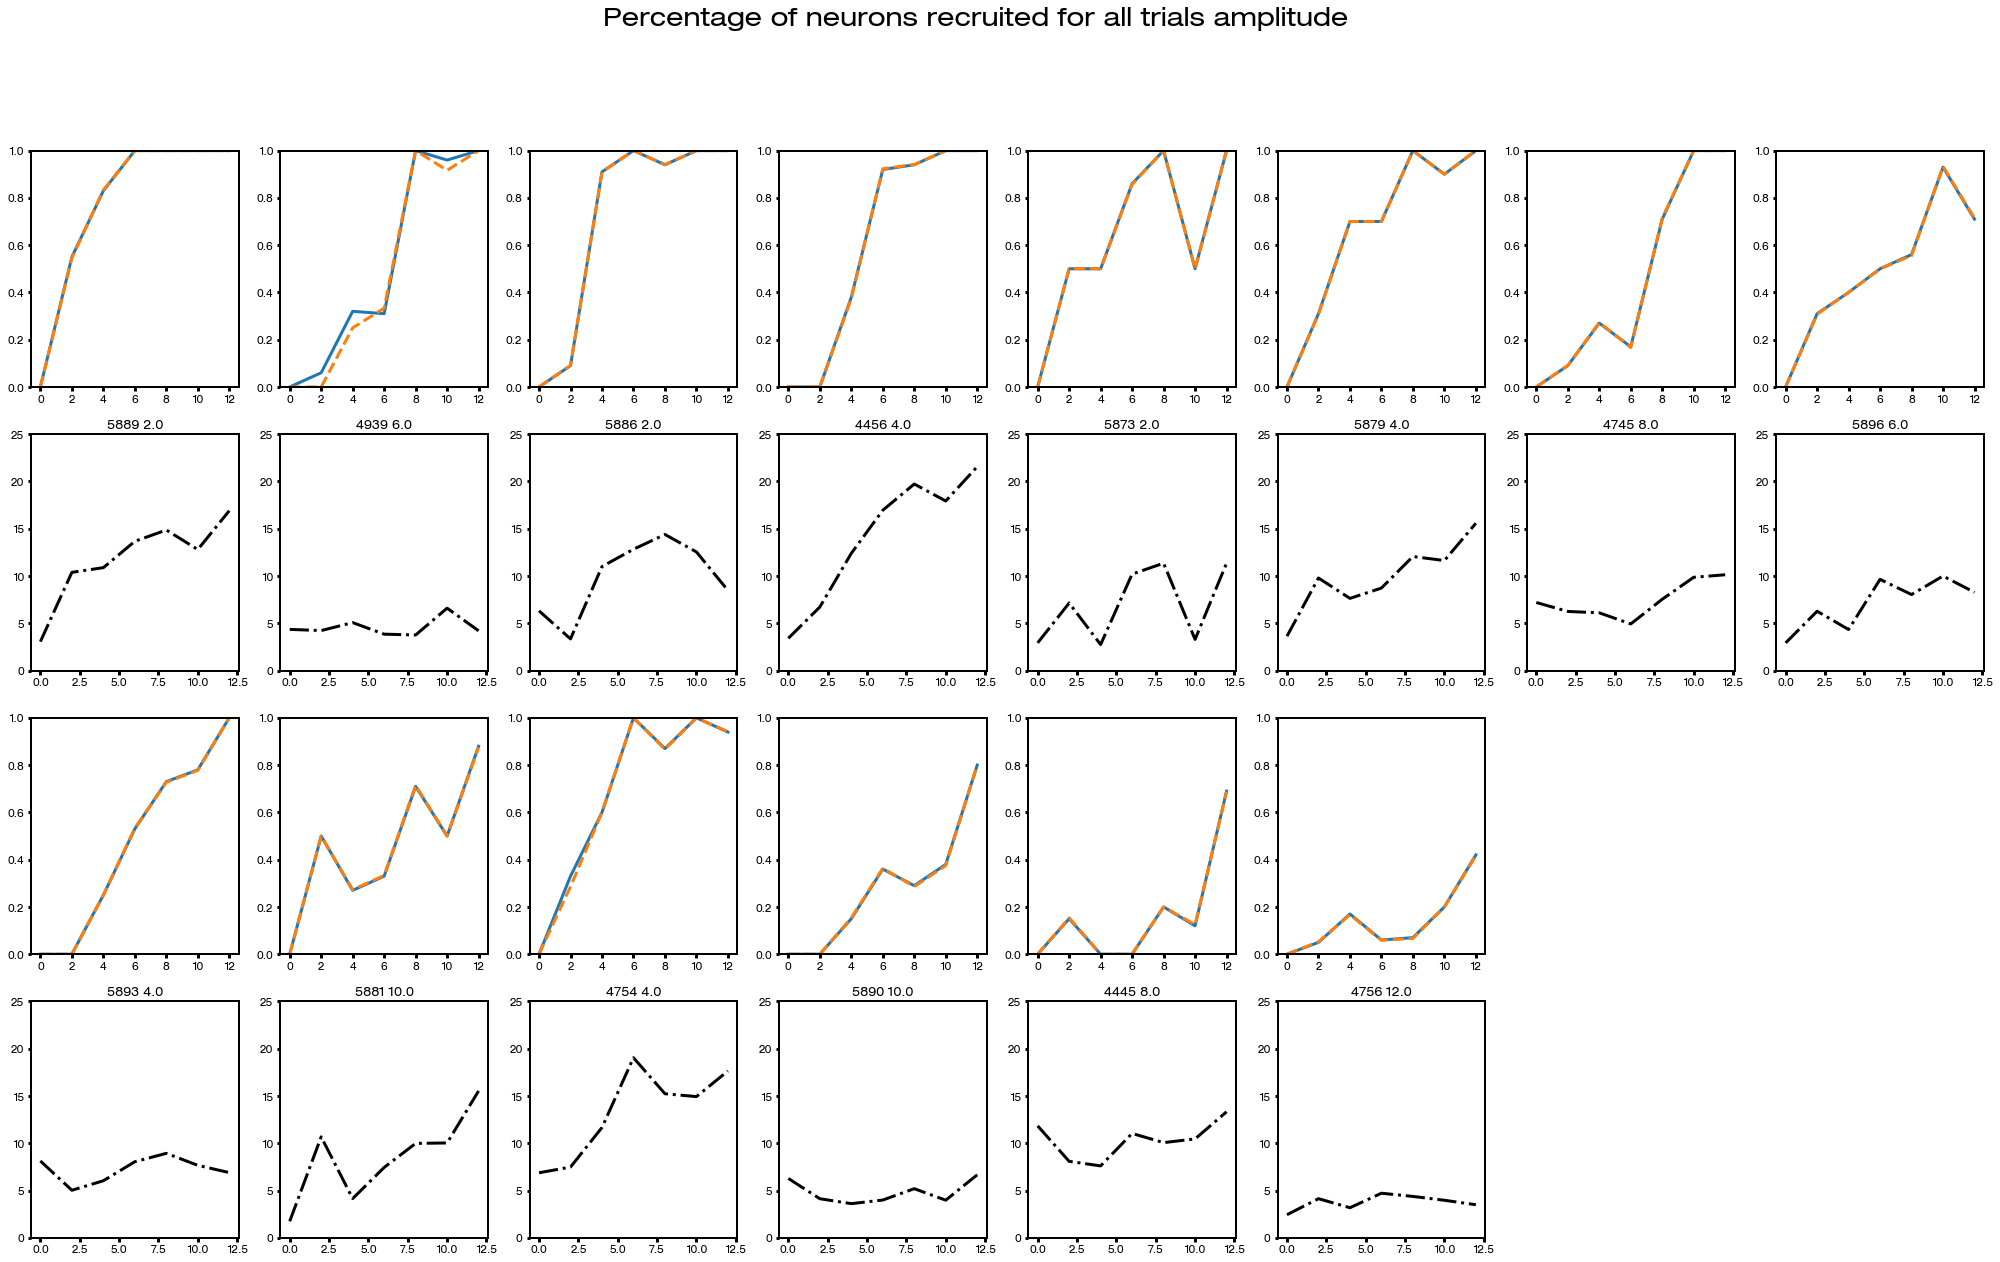

In [50]:
y, i = 0, 0
amps = [0, 2, 4, 6, 8, 10, 12]
fig, ax = plt.subplots(4, 8, figsize=(35, 20))

def neurons_recruited(ax, rec_, title):
    resp_mat = np.array(rec_.matrices["EXC"]["Responsivity"])
    print(resp_mat.shape)
    resp_p = []
    trials_bsl = resp_mat[:, rec_.stim_ampl == 0]
    trials_bsl[trials_bsl != 0] = 1
    bsl_neurons = np.mean(np.count_nonzero(trials_bsl, axis=0))
    for i, amp in enumerate(amps):
        trials_ = resp_mat[:, rec_.stim_ampl == amp]
        trials_[trials_ != 0] = 1
        recruited_det = np.count_nonzero(trials_, axis=0)
        perc_n_det = ((np.mean(recruited_det)) / len(rec_.zscore_exc)) * 100
        resp_p.append(perc_n_det)
    ax.plot(amps, resp_p, linestyle="-.", color="black",
                        markersize=15)
    ax.set_title(title)
    ax.set_ylim([0,25])
for rec in recs.values():
        print(rec.filename)
        # rec.responsivity()
        if rec.genotype == "WT":
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[0, i])
            neurons_recruited(ax[1, i], rec,str(rec.filename) + " " +str(rec.threshold))
            i = i + 1
        else:
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[2, y])
            neurons_recruited(ax[3, y], rec, str(rec.filename) + " " +str(rec.threshold))
            y = y + 1
ax[2, 6].set_axis_off()
ax[2, 7].set_axis_off()
ax[3, 6].set_axis_off()
ax[3, 7].set_axis_off()
fig.suptitle('Percentage of neurons recruited for all trials amplitude', fontsize=26)

5889
4939
5893
5886
4456
5873
5881
5879
4754
5890
4745
5896
4445
4756


/datas/Théo/Spikesorting/venv/Spikesorting2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/datas/Théo/Spikesorting/venv/Spikesorting2/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0.98, 'Percentage of neurons recruited for DETECTED TRIALS')

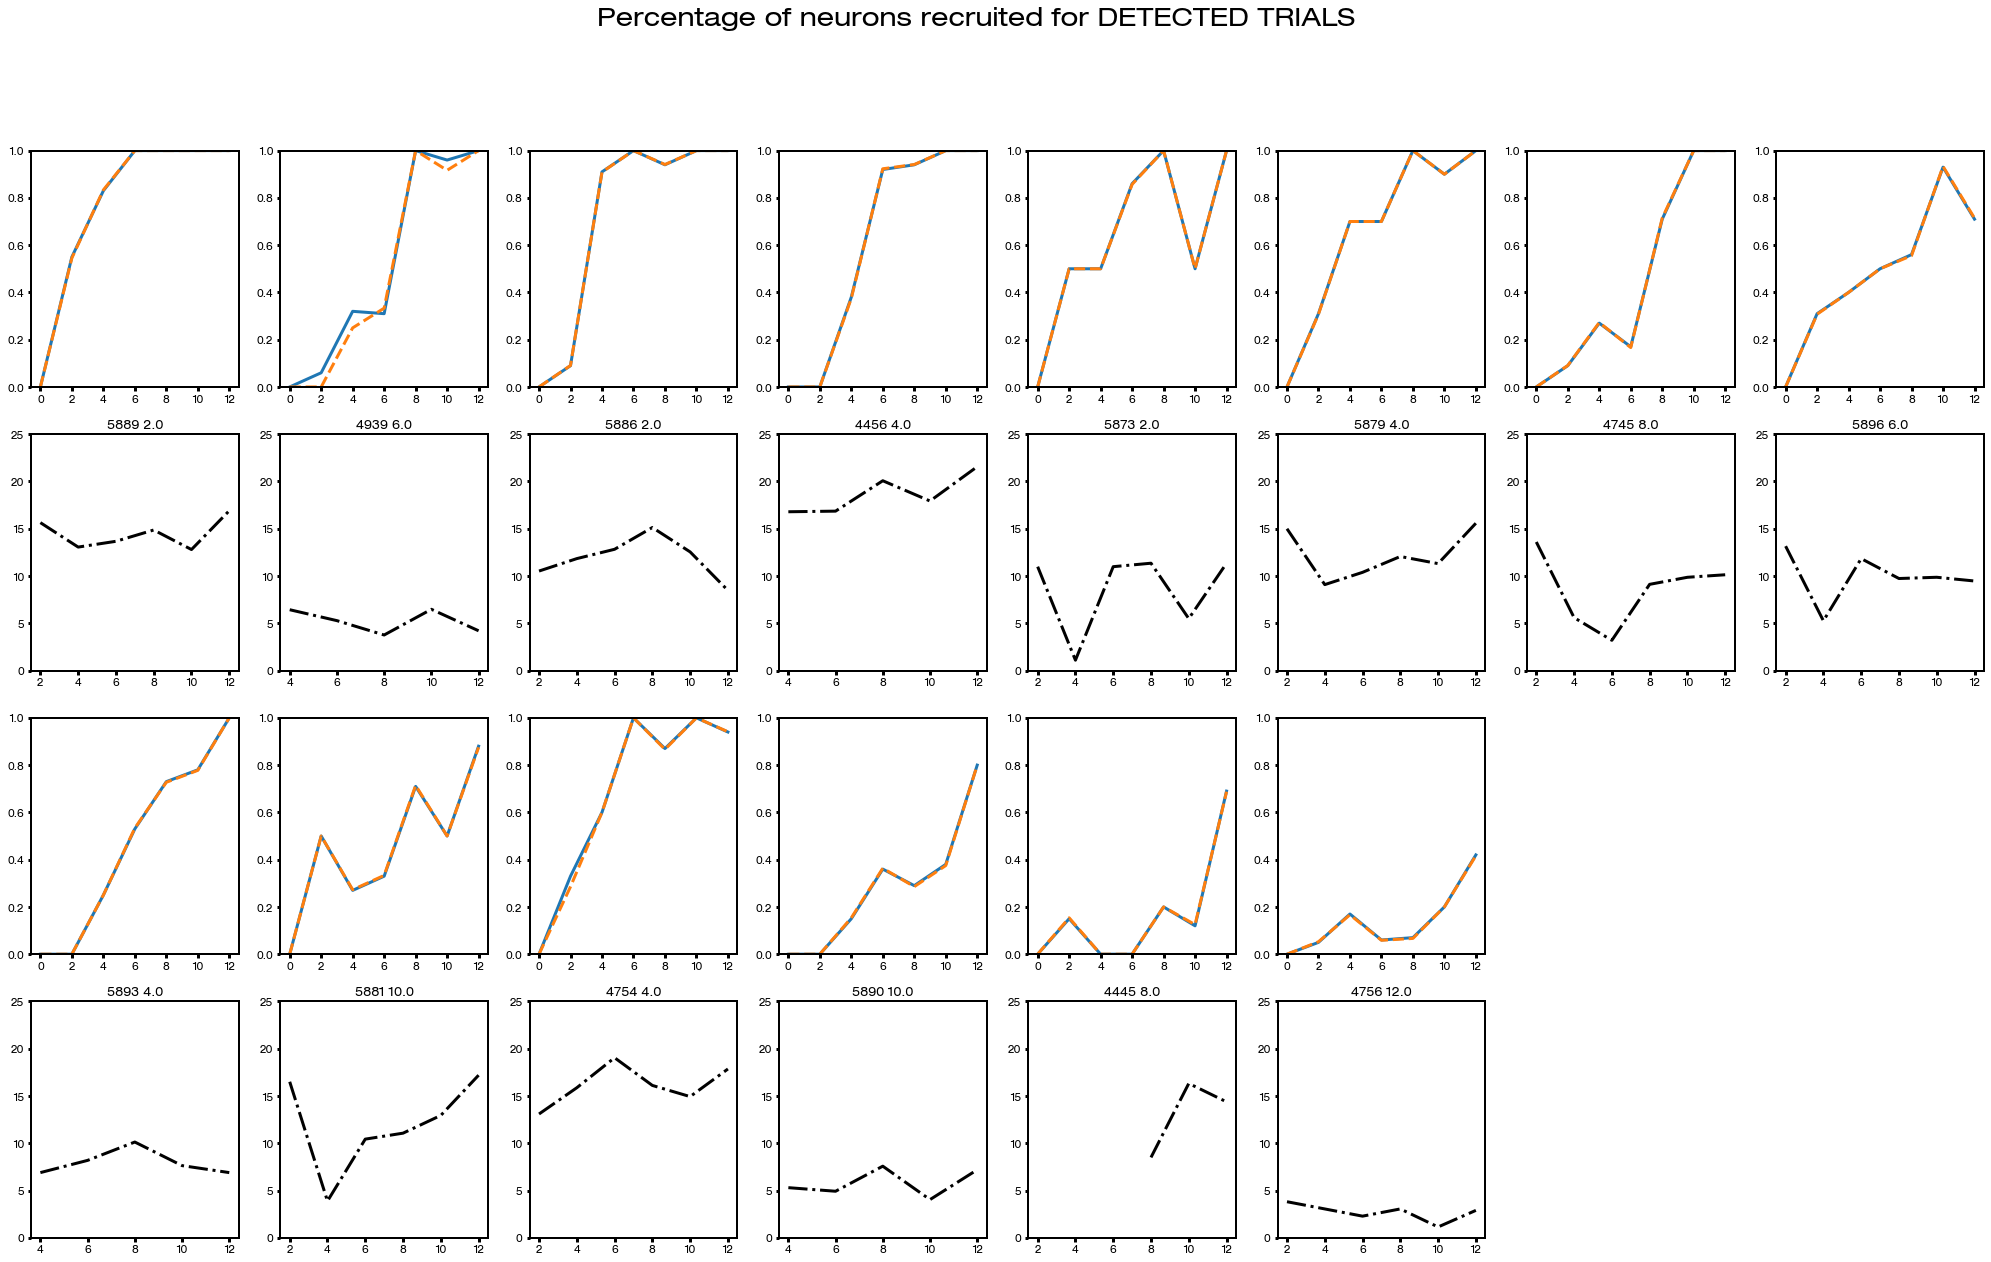

In [52]:
y, i = 0, 0
amps = [0, 2, 4, 6, 8, 10, 12]
fig, ax = plt.subplots(4, 8, figsize=(35, 20))

def neurons_recruited(ax, rec_, title):
    resp_mat = np.array(rec_.matrices["EXC"]["Responsivity"])
    resp_p = []
    trials_bsl = resp_mat[:, rec_.stim_ampl == 0]
    trials_bsl[trials_bsl != 0] = 1
    bsl_neurons = np.mean(np.count_nonzero(trials_bsl, axis=0))
    for i, amp in enumerate(amps):
        trials_ = resp_mat[:, (rec_.stim_ampl == amp)&(rec_.detected_stim)]
        trials_[trials_ != 0] = 1
        recruited_det = np.count_nonzero(trials_, axis=0)
        perc_n_det = ((np.mean(recruited_det)) / len(rec_.zscore_exc)) * 100
        resp_p.append(perc_n_det)
    ax.plot(amps, resp_p, linestyle="-.", color="black",
                        markersize=15)
    ax.set_title(title)
    ax.set_ylim([0,25])
for rec in recs.values():
        print(rec.filename)
        # rec.responsivity()
        if rec.genotype == "WT":
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[0, i])
            neurons_recruited(ax[1, i], rec,str(rec.filename) + " " +str(rec.threshold))
            i = i + 1
        else:
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[2, y])
            neurons_recruited(ax[3, y], rec, str(rec.filename) + " " +str(rec.threshold))
            y = y + 1
ax[2, 6].set_axis_off()
ax[2, 7].set_axis_off()
ax[3, 6].set_axis_off()
ax[3, 7].set_axis_off()
fig.suptitle('Percentage of neurons recruited for DETECTED TRIALS', fontsize=26)

percentage of neurons recruited for UNDETECTED TRIALS

5889
(49, 54)
4939
(101, 54)
5893
(58, 80)
5886
(38, 82)
4456
(127, 87)
5873
(91, 27)
5881
(103, 53)
5879
(55, 68)
4754
(42, 82)
5890
(66, 72)
4745
(125, 55)
5896
(76, 75)
4445
(98, 84)
4756
(131, 90)


/datas/Théo/Spikesorting/venv/Spikesorting2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/datas/Théo/Spikesorting/venv/Spikesorting2/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0.98, 'Percentage of neurons recruited for UNDETECTED TRIALS')

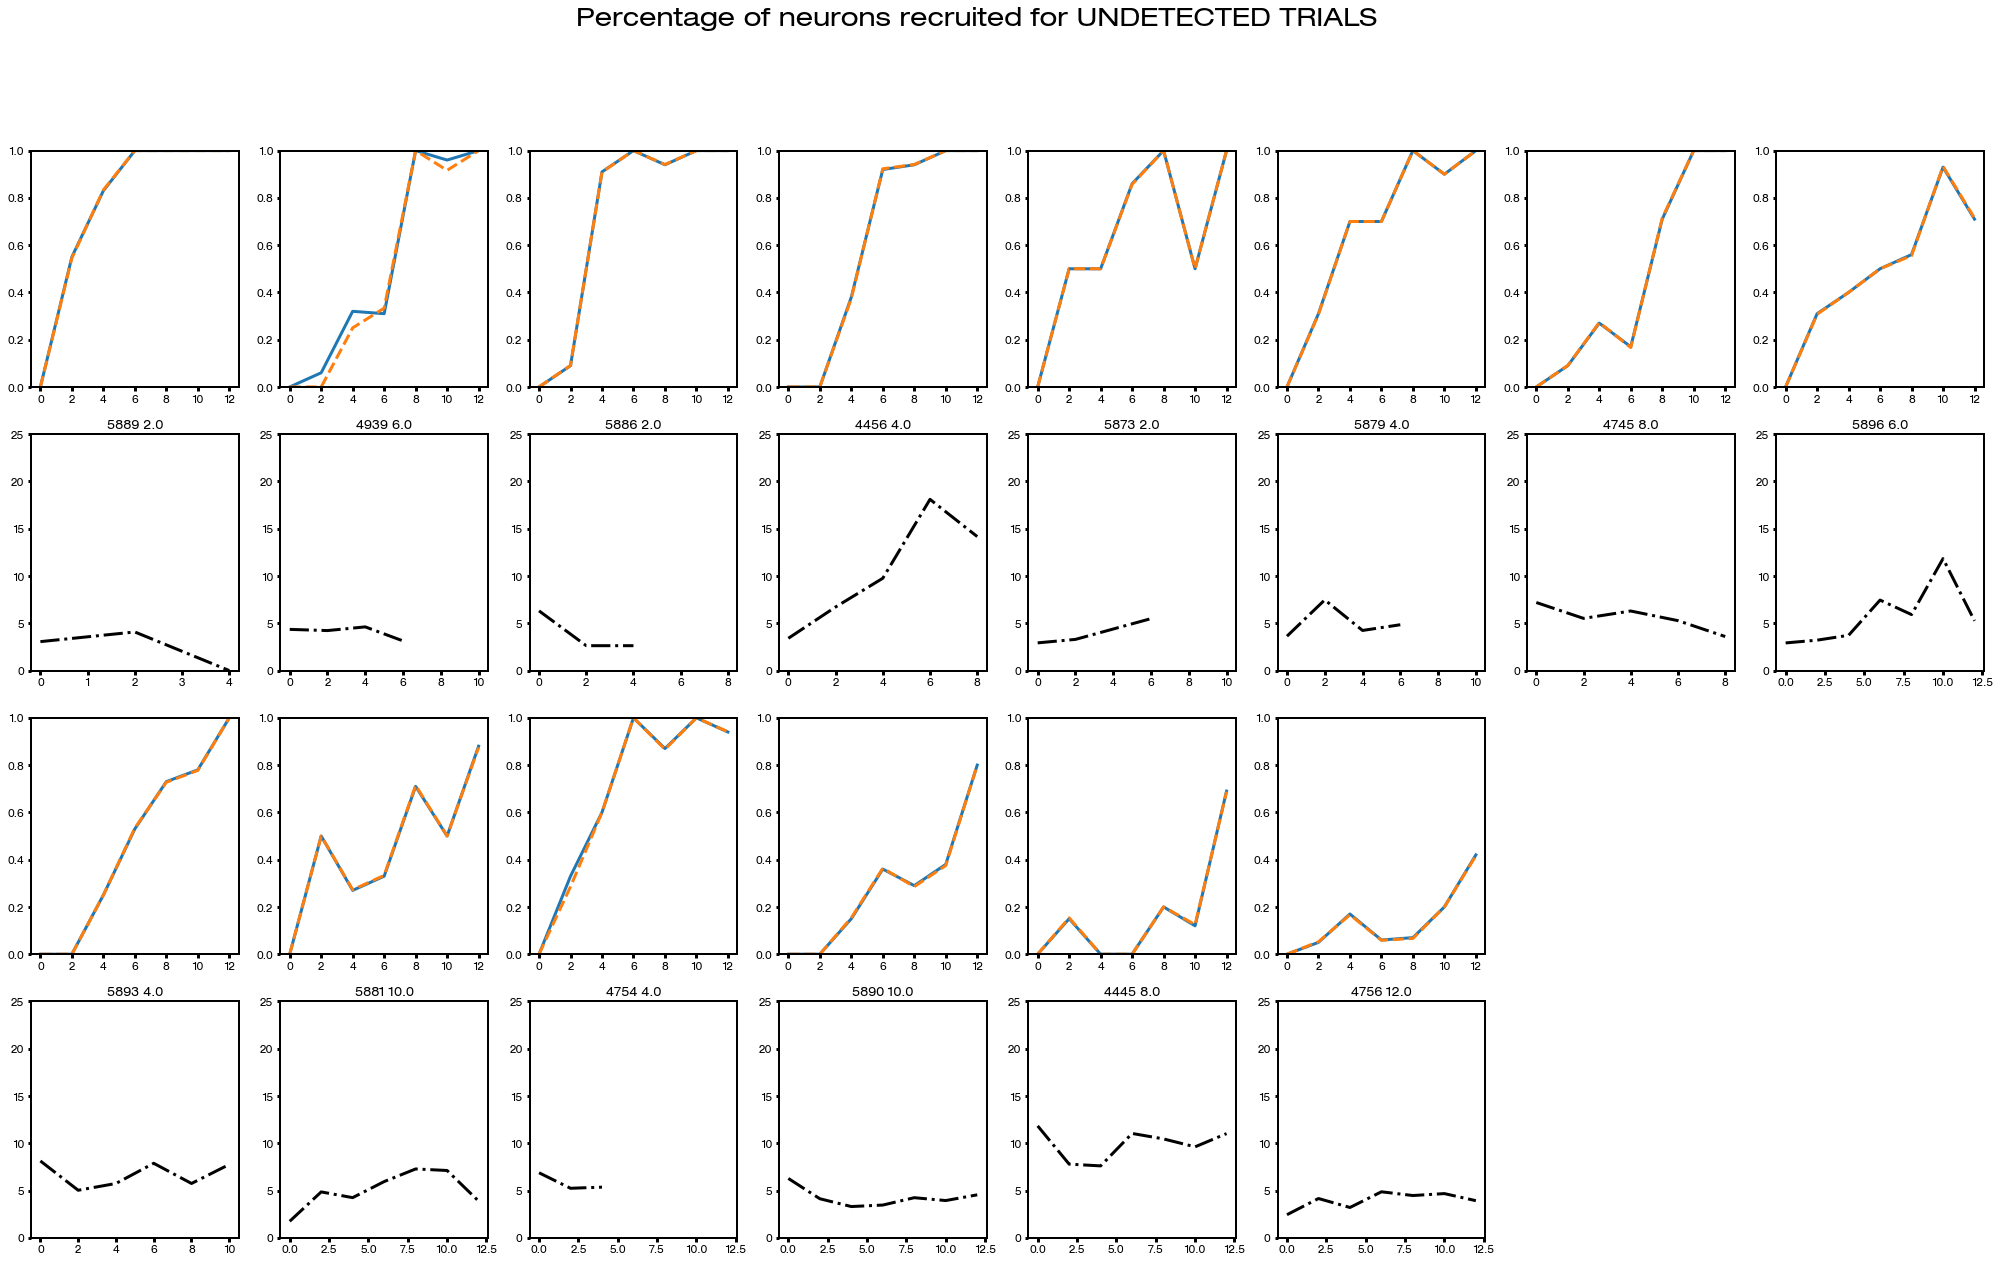

In [51]:
y, i = 0, 0
amps = [0, 2, 4, 6, 8, 10, 12]
fig, ax = plt.subplots(4, 8, figsize=(35, 20))

def neurons_recruited(ax, rec_, title):
    resp_mat = np.array(rec_.matrices["EXC"]["Responsivity"])
    resp_p = []
    trials_bsl = resp_mat[:, rec_.stim_ampl == 0]
    trials_bsl[trials_bsl != 0] = 1
    bsl_neurons = np.mean(np.count_nonzero(trials_bsl, axis=0))
    for i, amp in enumerate(amps):
        trials_ = resp_mat[:, (rec_.stim_ampl == amp)&(~rec_.detected_stim)]
        trials_[trials_ != 0] = 1
        recruited_det = np.count_nonzero(trials_, axis=0)
        perc_n_det = ((np.mean(recruited_det)) / len(rec_.zscore_exc)) * 100
        resp_p.append(perc_n_det)
    ax.plot(amps, resp_p, linestyle="-.", color="black",
                        markersize=15)
    ax.set_title(title)
    ax.set_ylim([0,25])
for rec in recs.values():
        print(rec.filename)
        # rec.responsivity()
        if rec.genotype == "WT":
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[0, i])
            neurons_recruited(ax[1, i], rec,str(rec.filename) + " " +str(rec.threshold))
            i = i + 1
        else:
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[2, y])
            neurons_recruited(ax[3, y], rec, str(rec.filename) + " " +str(rec.threshold))
            y = y + 1
ax[2, 6].set_axis_off()
ax[2, 7].set_axis_off()
ax[3, 6].set_axis_off()
ax[3, 7].set_axis_off()
fig.suptitle('Percentage of neurons recruited for UNDETECTED TRIALS', fontsize=26)